In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk

nltk.download("gutenberg")

[nltk_data] Downloading package gutenberg to /home/vscode/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [3]:
import re
from typing import Final, Sequence, TypeAlias

import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
from IPython.display import display
from matplotlib import pyplot as plt
from nltk.corpus import gutenberg
from numpy.typing import NDArray
from pandas import DataFrame

from authorship_tool.types_ import AuthorColl4dStr, Doc3dStr, Para2dStr, Tag
from authorship_tool.util import dim_reshaper
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.ml import cv_trainer, trainer
from authorship_tool.util.ml.model import (
    CrossValidationResult,
    CvGlobalExplanationData,
    LGBMSource,
    Score,
    ShapData,
    TrainingResult,
    pred_crosstab,
)

Project root: /workspaces/shap-authorship-analysis-demo
Path: data/john_blake_2023/wordLists/adjectives/participle/adjectivesPastParticiple.csv
Path: data/john_blake_2023/wordLists/adjectives/participle/adjectivesPresentParticiple.csv
Path: data/john_blake_2023/wordLists/adjectives/limit/limit_adjectives.csv
Path: data/john_blake_2023/wordLists/adjectives/extraposition/adjectives_extraposition.csv
Path: data/liyanage_vijini_2022/Dataset/FullyGenerated
Path: data/liyanage_vijini_2022/Dataset/Hybrid_AbstractDataset
Path: data/uoa-thesis-2014-2017
Path: out/text_data
Path: out/processed_text
Path: out/dataset
Path: out/lgbm/model
Path: out/shap/figure


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
np.seterr(divide="call")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [5]:
print(lgb.__version__)

4.4.0


In [6]:
for idx, file_id in enumerate(iterable=gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")

#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt


In [7]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors: set[Author] = {
    match.group(1)
    for file_id in gutenberg.fileids()
    if (match := re.search(r"^(.+?)-", file_id)) is not None
}

para_size_by_author: dict[Author, NumOfParas] = {}

for index, author in enumerate(authors):
    books_of_author: AuthorColl4dStr = [
        gutenberg.paras(fileids=file_id)
        for file_id in gutenberg.fileids()
        if author in file_id
    ]

    para_num: NumOfParas = len([para for paras in books_of_author for para in paras])
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")

1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs


In [8]:
AUTHOR_A: Final[str] = "shakespeare"
AUTHOR_B: Final[str] = "bryant"
PARAGRAPH_INIT_INDEX: Final[int] = 10
PARAGRAPH_END_INDEX: Final[int] = 1194

In [9]:
books_a: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_A in file_id
]

paras_a: Doc3dStr = [para for paras in books_a for para in paras][
    PARAGRAPH_INIT_INDEX:PARAGRAPH_END_INDEX
]

for para in paras_a[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs\n")

Fla . But wherefore art not in thy Shop to day ? Why do ' st thou leade these men about the streets ? Cob . Truly sir , to weare out their shooes , to get my selfe into more worke . But indeede sir , we make Holyday to see Caesar , and to reioyce in his Triumph
Mur . Wherefore reioyce ? What Conquest brings he home ? What Tributaries follow him to Rome , To grace in Captiue bonds his Chariot Wheeles ? You Blockes , you stones , you worse then senslesse things : O you hard hearts , you cruell men of Rome , Knew you not Pompey many a time and oft ? Haue you climb ' d vp to Walles and Battlements , To Towres and Windowes ? Yea , to Chimney tops , Your Infants in your Armes , and there haue sate The liue - long day , with patient expectation , To see great Pompey passe the streets of Rome : And when you saw his Chariot but appeare , Haue you not made an Vniuersall shout , That Tyber trembled vnderneath her bankes To heare the replication of your sounds , Made in her Concaue Shores ? And do

In [10]:
books_b: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_B in file_id
]

paras_b: Doc3dStr = [para for paras in books_b for para in paras][
    PARAGRAPH_INIT_INDEX:PARAGRAPH_END_INDEX
]

for para in paras_b[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs\n")

" Who is there ?" she said .
The same soft little voice answered , " It ' s the Rain , and I want to come in !"
" No , you can ' t come in ," said the little Tulip .
Then it was very still for a long time . At last , there came a little rustling , whispering sound , all round the window : _rustle , whisper , whisper_ .
" Who is there ?" said the little Tulip .
" It ' s the Sunshine ," said a little , soft , cheery voice , " and I want to come in !"
" N -- no ," said the little Tulip , " you can ' t come in ." And she sat still again .
Pretty soon she heard the sweet little rustling noise at the keyhole .
" Who is there ?" she said .
" It ' s the Sunshine ," said the cheery little voice , " and I want to come in , I want to come in !"
" No , no ," said the little Tulip , " you cannot come in ."
By and by , as she sat so still , she heard _tap , tap , tap_ , and _rustle , whisper , rustle_ , up and down the window - pane , and on the door and at the keyhole .
" _Who is there ? _ " she sa

In [11]:
print(f"total: {len(paras_a + paras_b)} paragraphs (samples)")

total: 2368 paragraphs (samples)


In [12]:
all_paras: list[Para2dStr] = paras_a + paras_b

all_pos: list[Tag] = PosFeature(all_paras).tag_subcategories().all_pos

print(all_pos)

["''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_exp', 'JJ_lim', 'JJ_pp', 'JJ_presp', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']


In [13]:
dataset_generator = ParagraphFeatureDatasetGenerator(tags=all_pos)

In [14]:
para_ans_pairs: Sequence[tuple[Para2dStr, bool]] = [
    (para, True) for para in paras_a
] + [(para, False) for para in paras_b]

In [15]:
dataset_list: list[pd.Series] = [
    dataset_generator.generate_from_paragraph(para, answer)
    for para, answer in para_ans_pairs
]

In [16]:
dataset: DataFrame = pd.concat(dataset_list, axis=1).reset_index(drop=True).T

In [17]:
dataset.columns = (*dataset_generator.columns, "answer")
for col, dtype in zip(
    dataset.columns,
    dataset_generator.dtypes + [bool],
    strict=True,
):
    dataset[col] = dataset[col].astype(dtype)

In [18]:
display(dataset.head(10))

,v1 sentences per paragraph,v2 words per paragraph,v3 close parenthesis present,v4 dash present,v5 semi-colon or colon present,v6 question mark present,v7 apostrophe present,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,v10 sentence with < 11 words,v11 sentence with > 34 words,v12 contains 'although',v13 contains 'however',v14 contains 'but',v15 contains 'because',v16 contains 'this',v17 contains 'others' or 'researchers',v18 contains numbers,v19 contains 2 times more capitals than period,v20 contains 'et',word variation,average word length,non alphabetic characters frequency,uncommon word frequency,non-alphabetic characters frequency,numeric value frequency,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,JJ_exp,JJ_lim,JJ_pp,JJ_presp,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,answer
0,6,60,False,False,False,True,True,6.191392,7.0,True,False,False,False,True,False,False,False,False,True,False,0.783333,3.366667,0.166667,0.666667,0.166667,0.0,0.016667,0.0,0.0,0.066667,0.083333,0.000000,0.050000,0.0,0.033333,0.0,0.0,0.066667,0.066667,0.016667,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.100000,0.083333,0.000000,0.066667,0.000000,0.0,0.016667,0.050000,0.016667,0.0,0.000000,0.016667,0.000000,0.083333,0.0,0.100000,0.016667,0.000000,0.000000,0.033333,0.000000,0.0,0.000000,0.0,0.016667,True
1,11,214,False,True,True,True,True,19.317273,18.8,True,True,False,False,True,False,True,False,False,True,False,0.621495,3.827103,0.149533,0.691589,0.149533,0.0,0.004673,0.0,0.0,0.084112,0.046729,0.014019,0.042056,0.0,0.046729,0.0,0.0,0.065421,0.042056,0.000000,0.004673,0.0,0.0,0.0,0.0,0.0,0.009346,0.079439,0.140187,0.009346,0.060748,0.000000,0.0,0.065421,0.051402,0.032710,0.0,0.000000,0.004673,0.000000,0.046729,0.0,0.051402,0.014019,0.000000,0.009346,0.042056,0.018692,0.0,0.009346,0.0,0.004673,True
2,1,49,False,False,True,False,False,0.000000,0.0,False,True,False,False,False,False,True,False,False,True,False,0.755102,3.714286,0.163265,0.653061,0.163265,0.0,0.000000,0.0,0.0,0.102041,0.040816,0.020408,0.040816,0.0,0.122449,0.0,0.0,0.081633,0.040816,0.000000,0.020408,0.0,0.0,0.0,0.0,0.0,0.000000,0.081633,0.163265,0.000000,0.081633,0.020408,0.0,0.020408,0.040816,0.000000,0.0,0.020408,0.000000,0.000000,0.020408,0.0,0.081633,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,True
3,2,6,False,False,False,False,False,1.000000,2.0,True,False,False,False,False,False,False,False,False,False,False,0.833333,3.833333,0.333333,0.666667,0.333333,0.0,0.000000,0.0,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.166667,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.333333,0.000000,0.000000,0.166667,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,True
4,1,46,False,True,True,False,True,0.000000,0.0,False,True,False,False,False,False,True,False,False,True,False,0.847826,3.847826,0.152174,0.652174,0.152174,0.0,0.021739,0.0,0.0,0.065217,0.000000,0.065217,0.000000,0.0,0.086957,0.0,0.0,0.086957,0.021739,0.000000,0.021739,0.0,0.0,0.0,0.0,0.0,0.021739,0.108696,0.043478,0.000000,0.021739,0.000000,0.0,0.108696,0.043478,0.021739,0.0,0.000000,0.021739,0.021739,0.000000,0.0,0.108696,0.000000,0.000000,0.021739,0.065217,0.000000,0.0,0.000000,0.0,0.021739,True
5,3,15,False,False,False,True,False,2.449490,3.0,True,False,False,False,False,False,False,False,False,True,False,1.000000,2.933333,0.133333,0.533333,0.133333,0.0,0.000000,0.0,0.0,0.000000,0.133333,0.000000,0.000000,0.0,0.066667,0.0,0.0,0.066667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.266667,0.000000,0.000000,0.000000,0.0,0.200000,0.000000,0.066667,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.133333,0.066667,0.0,0.000000,0.0,0.000000,True
6,3,74,False,False,True,False,False,16.048537,18.5,True,True,False,False,False,Fa

In [19]:
print(dataset.shape)

(2368, 73)


In [20]:
print(dataset.dtypes)

v1 sentences per paragraph                          int64
v2 words per paragraph                              int64
v3 close parenthesis present                         bool
v4 dash present                                      bool
v5 semi-colon or colon present                       bool
v6 question mark present                             bool
v7 apostrophe present                                bool
v8 standard deviation of sentence length          float64
v9 length difference for consecutive sentences    float64
v10 sentence with < 11 words                         bool
v11 sentence with > 34 words                         bool
v12 contains 'although'                              bool
v13 contains 'however'                               bool
v14 contains 'but'                                   bool
v15 contains 'because'                               bool
v16 contains 'this'                                  bool
v17 contains 'others' or 'researchers'               bool
v18 contains n

In [21]:
print(dataset.isna().sum())

v1 sentences per paragraph                        0
v2 words per paragraph                            0
v3 close parenthesis present                      0
v4 dash present                                   0
v5 semi-colon or colon present                    0
v6 question mark present                          0
v7 apostrophe present                             0
v8 standard deviation of sentence length          0
v9 length difference for consecutive sentences    0
v10 sentence with < 11 words                      0
v11 sentence with > 34 words                      0
v12 contains 'although'                           0
v13 contains 'however'                            0
v14 contains 'but'                                0
v15 contains 'because'                            0
v16 contains 'this'                               0
v17 contains 'others' or 'researchers'            0
v18 contains numbers                              0
v19 contains 2 times more capitals than period    0
v20 contains

In [22]:
display(dataset.describe())

,v1 sentences per paragraph,v2 words per paragraph,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,word variation,average word length,non alphabetic characters frequency,uncommon word frequency,non-alphabetic characters frequency,numeric value frequency,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,JJ_exp,JJ_lim,JJ_pp,JJ_presp,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
count,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.0,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.00000,2368.000000,2368.000000,2368.000000
mean,2.711149,41.868666,5.931692,9.196486,0.843767,3.441404,0.225184,0.706995,0.225184,0.0,0.007846,0.000342,0.000267,0.059430,0.082661,0.016068,0.031931,0.005301,0.070041,0.001840,0.000267,0.060374,0.048221,0.001581,0.001440,0.000202,0.000652,0.000180,0.000066,0.000322,0.012816,0.114456,0.152921,0.000876,0.022012,0.001051,0.003690,0.071362,0.023471,0.043091,0.001034,0.000438,0.003364,0.000147,0.015279,0.000864,0.036970,0.043536,0.005932,0.008963,0.021800,0.013703,0.00173,0.005251,0.000031,0.006179
std,2.010999,49.151027,7.480104,11.640898,0.136286,0.565738,0.119079,0.139563,0.119079,0.0,0.021522,0.002906,0.002466,0.052169,0.090077,0.027766,0.038512,0.021927,0.059641,0.008622,0.002962,0.051921,0.060320,0.008578,0.008004,0.002266,0.004012,0.002661,0.002258,0.006407,0.026353,0.092857,0.162120,0.009128,0.048291,0.006854,0.014635,0.060785,0.037524,0.049003,0.007029,0.004915,0.012629,0.002943,0.024605,0.007646,0.046364,0.050210,0.015589,0.020863,0.035837,0.028992,0.00760,0.016676,0.000474,0.017340
min,1.000000,1.000000,0.000000,0.000000,0.200000,1.000000,0.000000,0.394737,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1.000000,11.000000,0.000000,0.000000,0.750000,3.142857,0.150000,0.601389,0.150000,0.0,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065042,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,2.000000,25.000000,3.500000,5.928571,0.860000,3.446832,0.197603,0.684211,0.197603,0.0,0.000000,0.000000,0.000000,0.058824,0.052632,0.000000,0.025000,0.000000,0.067512,0.000000,0.000000,0.062500,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.107143,0.000000,0.000000,0.000000,0.000000,0.066987,0.000000,0.032787,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.024077,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,3.000000,54.000000,8.961716,13.333333,1.000000,3.712983,0.280513,0.777778,0.280513,0.0,0.000000,0.000000,0.000000,0.090909,0.111111,0.027531,0.052632,0.000000,0.105370,0.000000,0.000000,0.097845,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016737,0.153846,0.200000,0.000000,0.032984,0.000000,0.000000,0.108255,0

In [23]:
df: DataFrame = dataset.iloc[:, :-1]
nd_category: NDArray = dataset.iloc[:, -1].to_numpy(dtype=np.bool_)

In [24]:
source: LGBMSource = LGBMSource(feature_data_frame=df, nd_category=nd_category)
result: TrainingResult = trainer.train_once(source)

[LightGBM] [Info] Number of positive: 942, number of negative: 952
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7232
[LightGBM] [Info] Number of data points in the train set: 1894, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497360 -> initscore=-0.010560
[LightGBM] [Info] Start training from score -0.010560


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [25]:
score: Score | None = result.score

In [26]:
if score is not None:
    print(f"auc-roc score: {score.auc_roc_score}")
    print(f"f1 score: {score.f1_score}")
    print(f"accuracy score: {score.accuracy_score}")

auc-roc score: 0.9924658022228554
f1 score: 0.9652351738241309
accuracy score: 0.9641350210970464


In [27]:
display(pred_crosstab(result.splitted_dataset.test_ans, result.prediction.pred_ans))

predicted,False,True
actual,,
False,221,11
True,6,236


In [28]:
FIRST_DATA_INDEX: Final[int] = 0
shap_data: ShapData = result.shap_data
explainer: shap.Explainer = shap_data.explainer

local_explanation = shap.Explanation(
    base_values=shap_data.base_values,
    values=shap_data.shap_values[FIRST_DATA_INDEX],
    data=shap_data.data.to_numpy()[FIRST_DATA_INDEX],
    feature_names=shap_data.data.columns,
)

global_explanation = shap.Explanation(
    base_values=shap_data.base_values,
    values=shap_data.shap_values,
    data=shap_data.data.to_numpy(),
    feature_names=shap_data.data.columns,
)

In [29]:
shap.initjs()

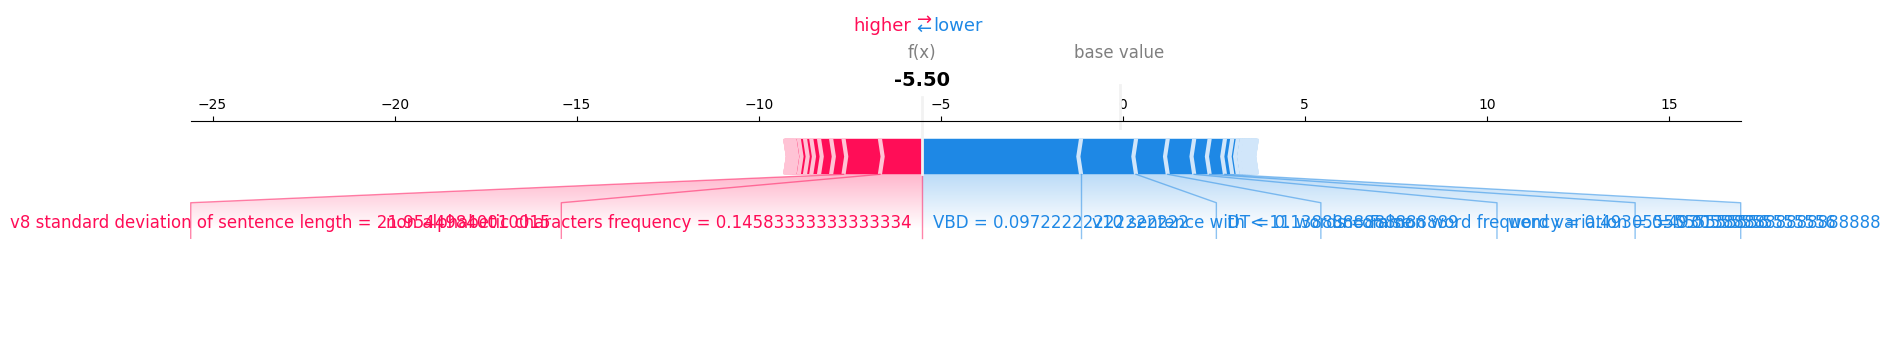

<Figure size 640x480 with 0 Axes>

In [31]:
shap.plots.force(local_explanation)
shap.plots.force(
    local_explanation,
    matplotlib=True,
    show=False,
)
plt.show()
plt.clf()

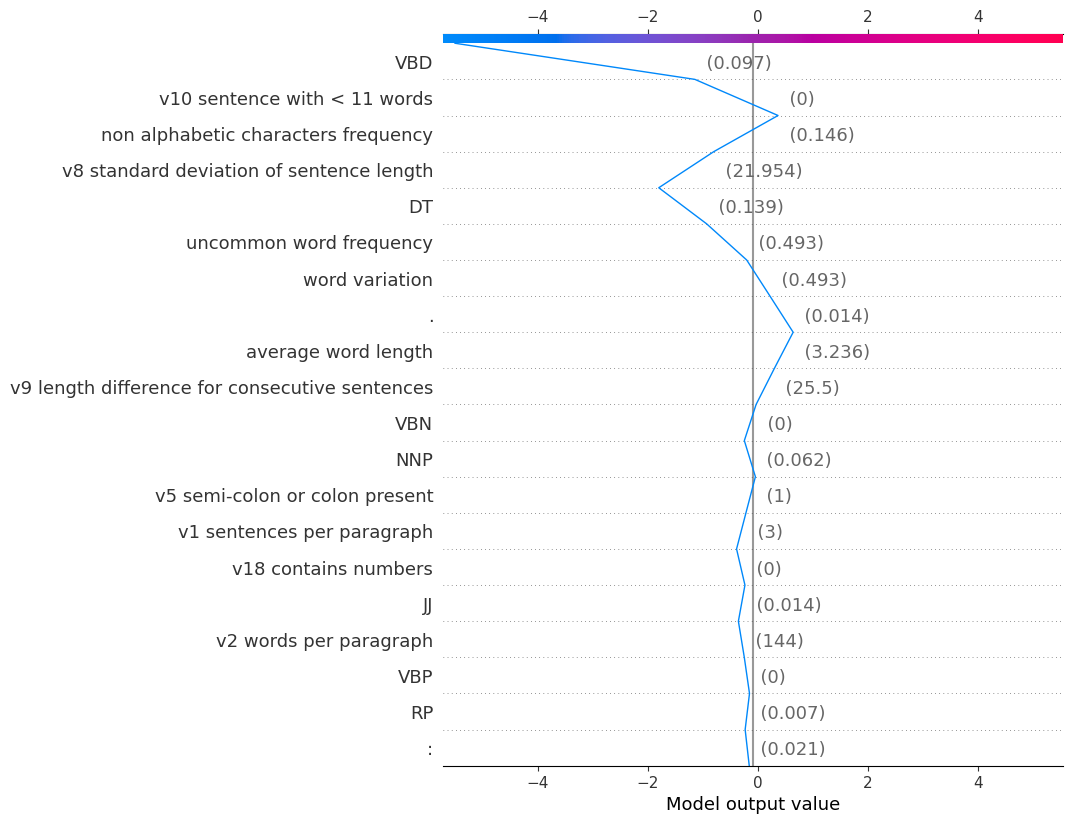

<Figure size 640x480 with 0 Axes>

In [32]:
shap.plots.decision(
    base_value=local_explanation.base_values,
    shap_values=local_explanation.values,
    features=local_explanation.data,
    feature_names=local_explanation.feature_names,
)
plt.show()
plt.clf()

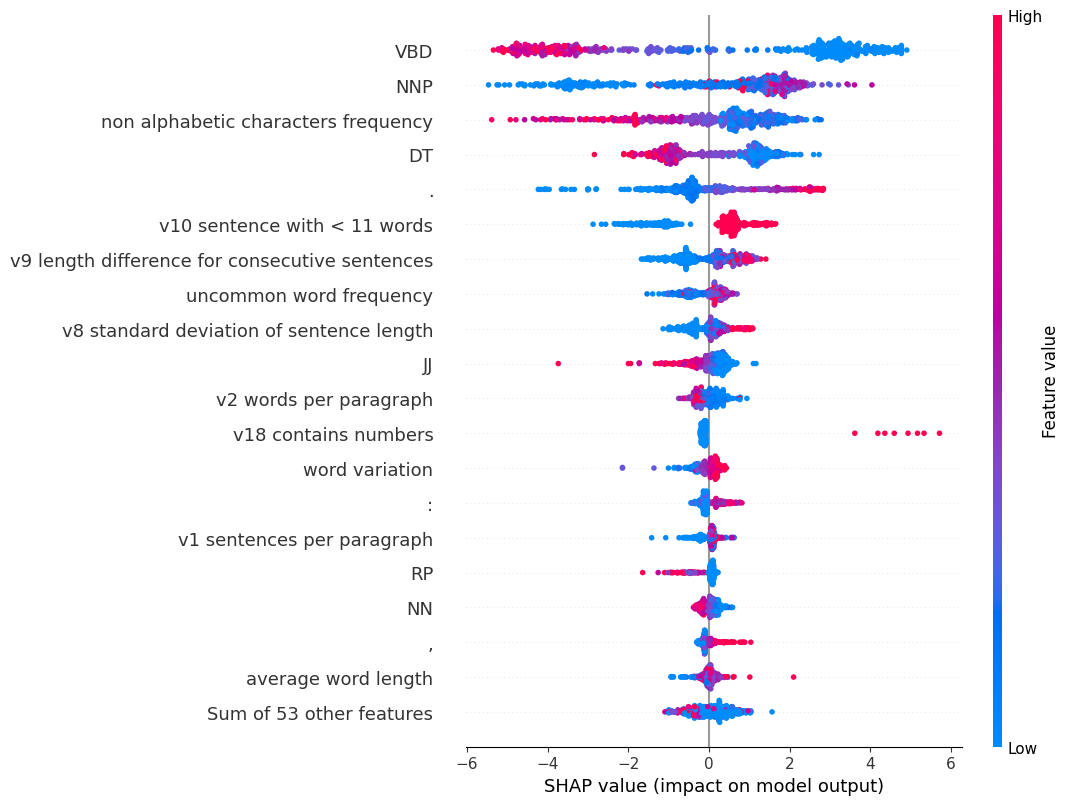

<Figure size 640x480 with 0 Axes>

In [33]:
shap.plots.beeswarm(
    global_explanation,
    max_display=20,
    show=False,
)
plt.show()
plt.clf()

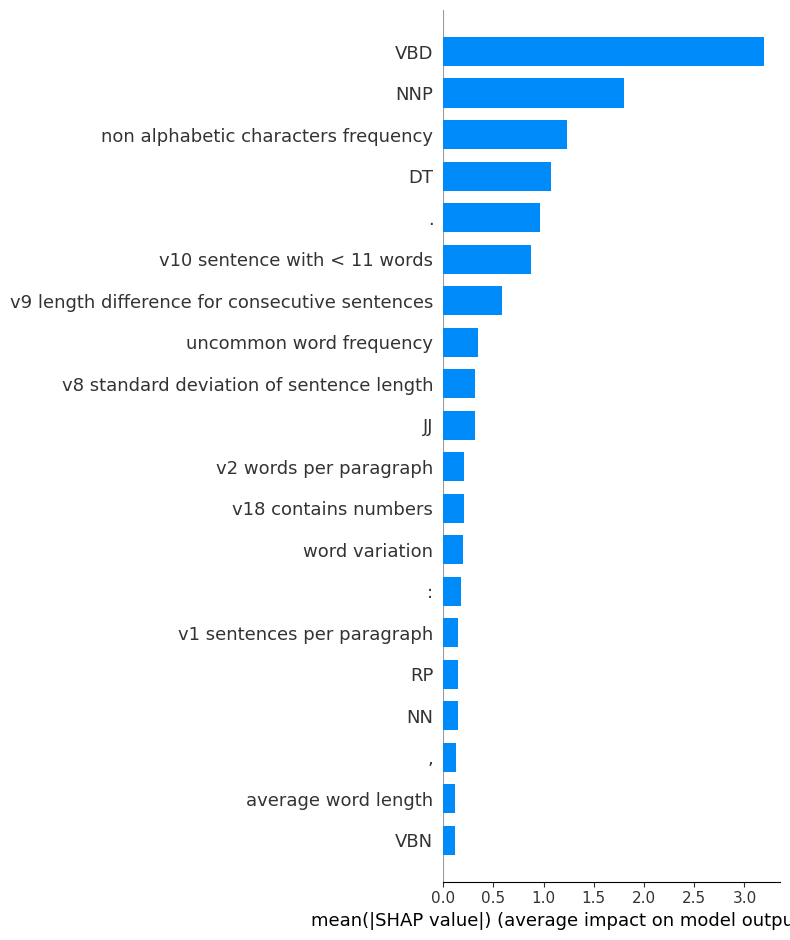

<Figure size 640x480 with 0 Axes>

In [34]:
shap.summary_plot(
    global_explanation,
    plot_type="bar",
    show=False,
)
plt.show()
plt.clf()

In [35]:
results_for_each_iters: list[TrainingResult] = cv_trainer.train_kfold(source, 100)

[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7581
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7582
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7580
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7581
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501280 -> initscore=0.005119
[LightGBM] [Info] Start training from score 0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7587
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7601
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7567
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7575
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7578
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7579
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119
[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7581
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7584
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501280 -> initscore=0.005119
[LightGBM] [Info] Start training from score 0.005119
[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7565
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1167, number of negative: 1177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7588
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497867 -> initscore=-0.008532
[LightGBM] [Info] Start training from score -0.008532


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1176, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7570
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM] [Info] Start training from score 0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7583
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7575
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1176, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7587
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM] [Info] Start training from score 0.006826
[LightGBM] [Info] Number of positive: 1168, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7583
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498294 -> initscore=-0.006826
[LightGBM] [Info] Start training from score -0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7583
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7591
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1176, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7577
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM] [Info] Start training from score 0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1167, number of negative: 1177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7594
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497867 -> initscore=-0.008532
[LightGBM] [Info] Start training from score -0.008532


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7577
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7575
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501280 -> initscore=0.005119
[LightGBM] [Info] Start training from score 0.005119
[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7552
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7580
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7586
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7578
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7568
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7579
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413
[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7566
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7600
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1177, number of negative: 1167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7594
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502133 -> initscore=0.008532
[LightGBM] [Info] Start training from score 0.008532


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7568
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7583
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7579
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119
[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7568
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1168, number of negative: 1176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7567
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498294 -> initscore=-0.006826
[LightGBM] [Info] Start training from score -0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7578
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7580
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7592
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1168, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7580
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498294 -> initscore=-0.006826
[LightGBM] [Info] Start training from score -0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7582
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7567
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7577
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413
[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7585
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7579
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7577
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1168, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7582
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498294 -> initscore=-0.006826
[LightGBM] [Info] Start training from score -0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7584
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7476
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7564
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7589
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7572
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7583
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7577
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7584
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7568
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1176, number of negative: 1168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7565
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM] [Info] Start training from score 0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7585
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7599
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413
[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7579
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7574
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7574
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7581
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501280 -> initscore=0.005119
[LightGBM] [Info] Start training from score 0.005119
[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7595
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7599
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413
[LightGBM] [Info] Number of positive: 1167, number of negative: 1178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7577
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497655 -> initscore=-0.009382
[LightGB

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7575
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559
[LightGBM] [Info] Number of positive: 1171, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7483
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499360 -> initscore=-0.002559
[LightGBM] [Info] Start training from score -0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7477
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498934 -> initscore=-0.004264
[LightGBM] [Info] Start training from score -0.004264
[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7584
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7570
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499787 -> initscore=-0.000853
[LightGBM] [Info] Start training from score -0.000853
[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7583
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM] [Info] Start training from score 0.000853


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7588
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM] [Info] Start training from score 0.000853
[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7597
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7574
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499787 -> initscore=-0.000853
[LightGBM] [Info] Start training from score -0.000853


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1176, number of negative: 1169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7488
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501493 -> initscore=0.005970
[LightGBM] [Info] Start training from score 0.005970


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7582
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7583
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7585
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498507 -> initscore=-0.005970
[LightGBM] [Info] Start training from score -0.005970


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7587
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7572
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499360 -> initscore=-0.002559
[LightGBM] [Info] Start training from score -0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1177, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7588
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501919 -> initscore=0.007676
[LightGBM] [Info] Start training from score 0.007676


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7560
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7587
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7580
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7579
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498507 -> initscore=-0.005970
[LightGBM] [Info] Start training from score -0.005970


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7563
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7569
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498934 -> initscore=-0.004264
[LightGBM] [Info] Start training from score -0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7577
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7578
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7571
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499787 -> initscore=-0.000853
[LightGBM] [Info] Start training from score -0.000853


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7577
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM] [Info] Start training from score 0.000853


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7583
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7576
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7571
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM] [Info] Start training from score 0.000853


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7574
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499360 -> initscore=-0.002559
[LightGBM] [Info] Start training from score -0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7563
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [36]:
cv_result: CrossValidationResult = cv_trainer.convert_results_to_cv_result(
    results_for_each_iters
)

In [37]:
cv_global_exp_data: CvGlobalExplanationData = (
    cv_trainer.convert_cv_result_to_global_exp_data(cv_result)
)

In [38]:
cv_score: Score = cv_trainer.calc_score_for_cv(cv_global_exp_data)

In [39]:
if cv_score is not None:
    print(f"auc-roc score:\t{cv_score.auc_roc_score}")
    print(f"f1 score:\t{cv_score.f1_score}")
    print(f"accuracy score:\t{cv_score.accuracy_score}")

auc-roc score:	0.9954460372534697
f1 score:	0.9734289329396879
accuracy score:	0.9733952702702703


In [40]:
display(pred_crosstab(cv_global_exp_data.test_ans, cv_global_exp_data.pred_ans))

predicted,False,True
actual,,
False,1151,33
True,30,1154


In [41]:
test_data = cv_global_exp_data.test_data
shap_vals = cv_global_exp_data.shap_vals

cv_global_explanation = shap.Explanation(
    values=shap_vals,
    data=test_data,
)

In [42]:
shap.initjs()

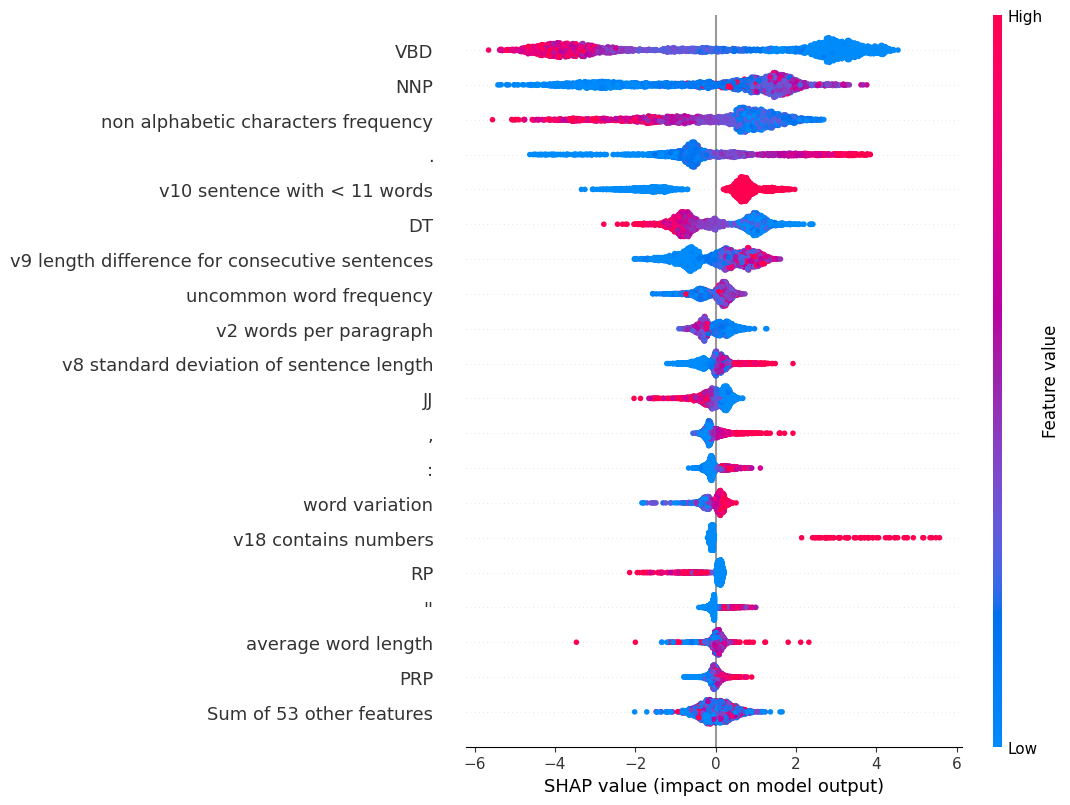

<Figure size 640x480 with 0 Axes>

In [45]:
shap.plots.beeswarm(
    cv_global_explanation,
    max_display=20,
    show=False,
)
plt.show()
plt.clf()

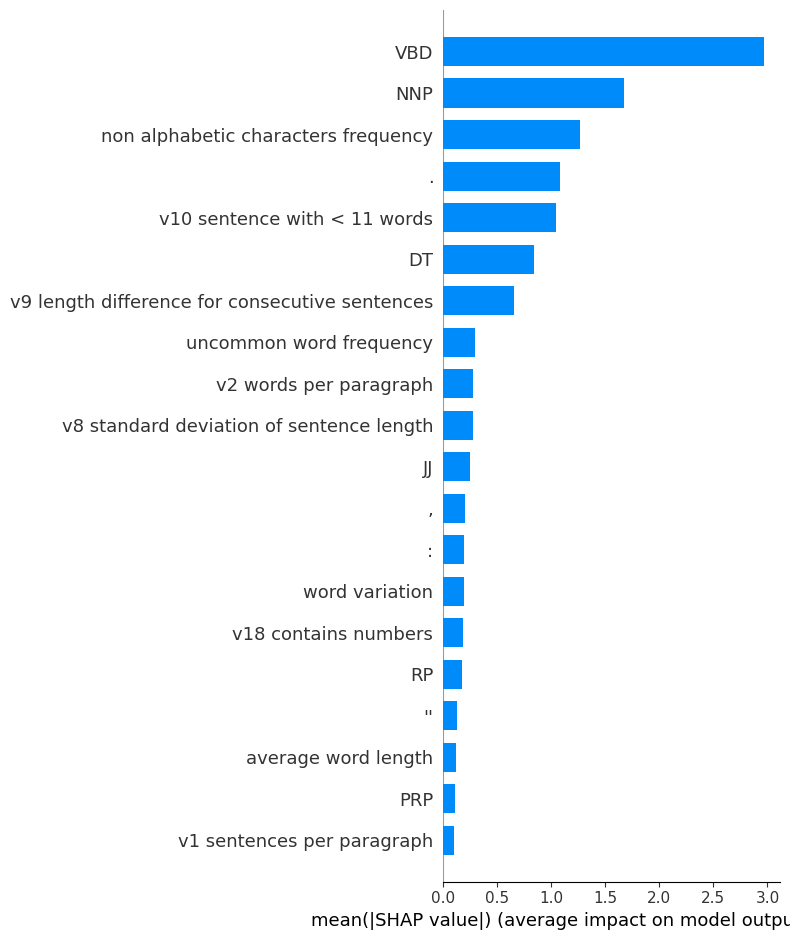

<Figure size 640x480 with 0 Axes>

In [47]:
shap.summary_plot(
    cv_global_explanation,
    plot_type="bar",
    show=False,
)
plt.show()
plt.clf()